
# Explaining Measures of Fairness with SHAP


https://github.com/slundberg/shap/blob/master/notebooks/general/Explaining%20Quantitative%20Measures%20of%20Fairness.ipynb


In [1]:
#%tensorflow_version 1.x
import logging;logging.basicConfig(level=logging.INFO);
# from tqdm import tqdm_notebook as tqdm

In [2]:
# here we define a function that we can call to execute our simulation under
# a variety of different alternative scenarios
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import shap
%config InlineBackend.figure_format = 'retina'
def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0, income_sex_impact=0,
                          late_payments_sex_impact=0, default_rate_sex_impact=0,
                          include_brandx_purchase_score=False, include_sex=False):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1 # randomly half men and half women
    
    # four hypothetical causal factors influence customer quality
    # they are all scaled to the same units between 0-1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    if income_sex_impact > 0:
        income_amount -= income_sex_impact/90000 * sex * np.random.rand(N)
        income_amount -= income_amount.min()
        income_amount /= income_amount.max()
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)
    
    # intuitively this product says that high customer quality comes from simultaneously
    # being strong in all factors 
    customer_quality = income_stability * income_amount * spending_restraint * consistency 
    
    # job history is a random function of the underlying income stability feature
    job_history = np.maximum(
        10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N)
    , 0)
    
    # reported income is a random function of the underlying income amount feature
    reported_income =  np.maximum(
        10000 + 90000*income_amount + np.random.randn(N) * 10000 - \
        reported_income_sex_impact * sex * np.random.rand(N)
    , 0)
    
    # credit inquiries is a random function of the underlying spending restraint and income amount features
    credit_inquiries = np.round(6 * np.maximum(-spending_restraint + income_amount, 0)) + \
                       np.round(np.random.rand(N) > 0.1)
    
    # credit inquiries is a random function of the underlying consistency and income stability features
    late_payments = np.maximum(
        np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + \
        np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N))
    , 0)
    
    # bundle everything into a data frame and define the labels based on the default rate and customer quality
    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    }, dtype=np.float32)
    default_rate = 0.40 + sex * default_rate_sex_impact
    y = customer_quality < np.percentile(customer_quality, default_rate * 100) 
    
    cquality = customer_quality

    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score
    
    if include_sex:
        X["Sex"] = sex + 0
    
    # build model
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500,subsample=0.5,learning_rate=0.05)
    model.fit(X, y)
    # print(model.evals_result())

    # build explanation
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)
    
    return shap_values, sex, X, explainer.expected_value, y, cquality


Scenario A: No reporting errors

Our first experiment is a simple baseline check where we refrain from introducing any sex-specific reporting errors. While we could use any model output to measure demographic parity, we use the continuous log-odds score from a binary XGBoost classifier. As expected, this baseline experiment results in no significant demographic parity difference between the credit scores of men and women. We can see this by plotting the difference between the average credit score for women and men as a bar plot and noting that zero is close to the margin of error (note that negative values mean women have a lower average predicted risk than men, and positive values mean that women have a higher average predicted risk than men):


In [3]:
N = 10000
shap_values_A, sex_A, X_A, ev_A, y_A, cquality_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
# shap.group_difference_plot(shap_values_A.sum(1), sex_A, xmin=xmin, xmax=xmax, xlabel=glabel)

 98%|===================| 9785/10000 [00:17<00:00]        

<BarContainer object of 1 artists>

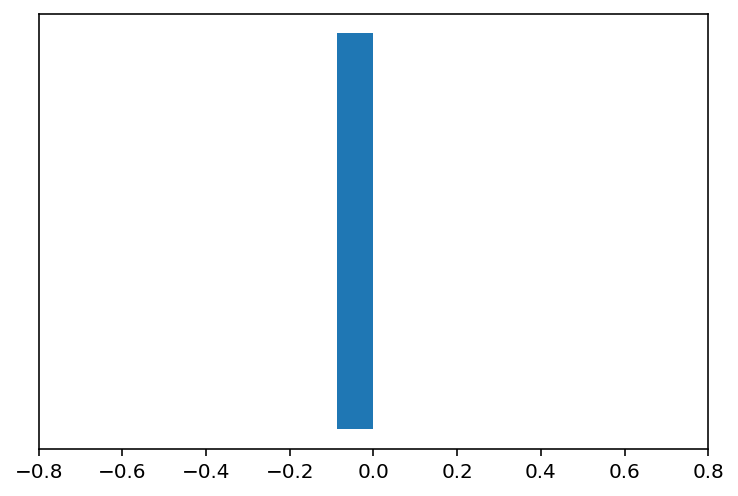

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
ax.barh(0,height=0.1, width=(shap_values_A.sum(1)[sex_A].mean()-shap_values_A.sum(1)[sex_A==False].mean()))

In [5]:
shap_values_A.sum(1)[sex_A].mean()

0.1624641465381311

In [6]:
shap_values_A.sum(1)[sex_A==False].mean()

0.24873828156229713

<BarContainer object of 4 artists>

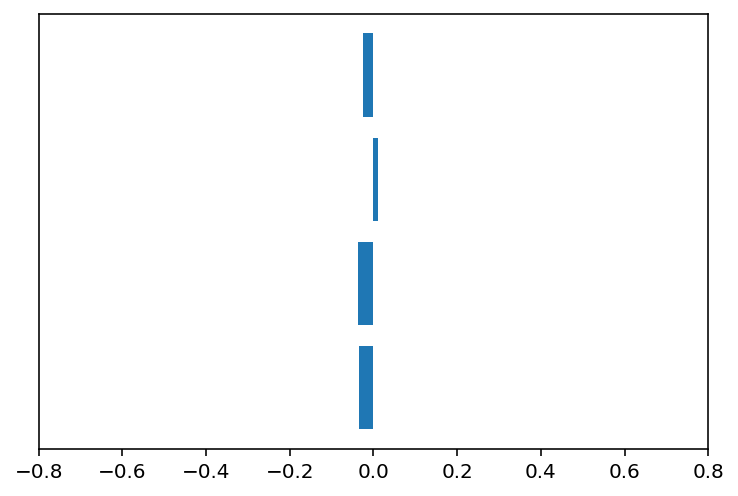

In [7]:
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
wdt = [shap_values_A[:,0][sex_A].mean() - shap_values_A[:,0][sex_A==False].mean(),
       shap_values_A[:,1][sex_A].mean() - shap_values_A[:,1][sex_A==False].mean(),
       shap_values_A[:,2][sex_A].mean() - shap_values_A[:,2][sex_A==False].mean(),
       shap_values_A[:,3][sex_A].mean() - shap_values_A[:,3][sex_A==False].mean()]
ax.barh(y=[1,2,3,4], width=wdt)

In [8]:
shap_values_B, sex_B, X_B, ev_B, y, cquality = run_credit_experiment(N, reported_income_sex_impact=30000)

 95%|=================== | 9493/10000 [00:16<00:00]       

<BarContainer object of 1 artists>

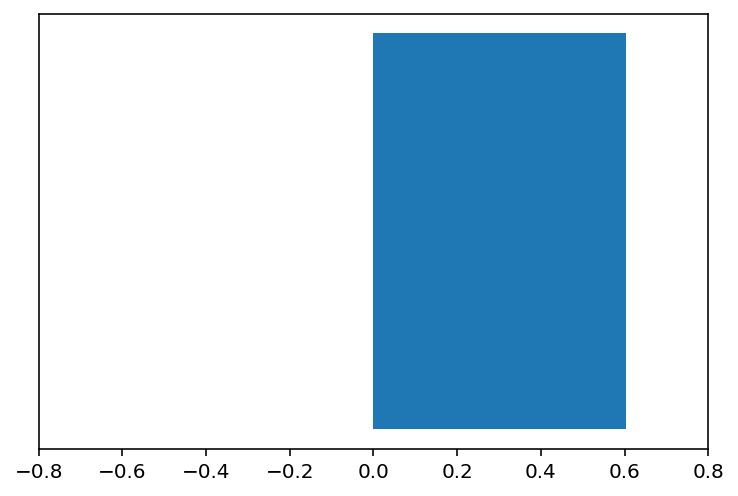

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
ax.barh(0,height=0.1, width=(shap_values_B.sum(1)[sex_B].mean()-shap_values_B.sum(1)[sex_B==False].mean()))

<BarContainer object of 4 artists>

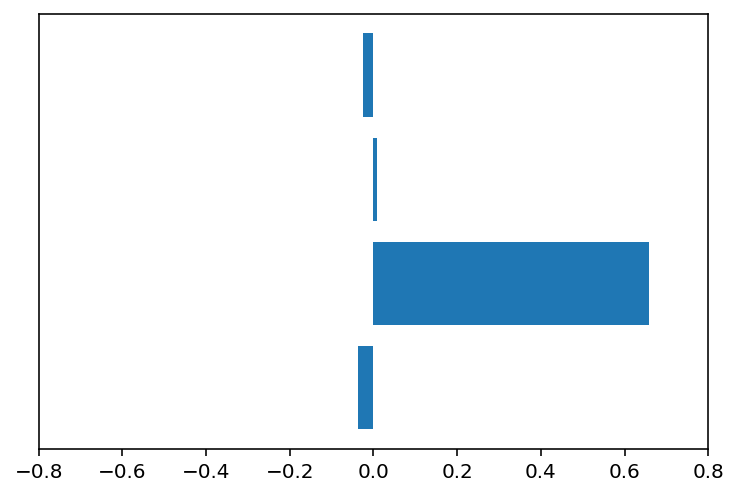

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
wdt = [shap_values_B[:,0][sex_B].mean() - shap_values_B[:,0][sex_B==False].mean(),
       shap_values_B[:,1][sex_B].mean() - shap_values_B[:,1][sex_B==False].mean(),
       shap_values_B[:,2][sex_B].mean() - shap_values_B[:,2][sex_B==False].mean(),
       shap_values_B[:,3][sex_B].mean() - shap_values_B[:,3][sex_B==False].mean()]
ax.barh(y=[1,2,3,4], width=wdt)

In [11]:
X_A[sex_A].describe()

,Job history,Reported income,Credit inquiries,Late payments
count,5085.000000,5085.000000,5085.000000,5085.000000
mean,5.982969,55364.871094,1.919961,2.704031
std,2.939514,27905.386719,1.467885,0.955909
min,0.130696,0.000000,0.000000,0.000000
25%,3.513459,32867.007812,1.000000,2.000000
50%,6.001924,55276.941406,1.000000,3.000000
75%,8.491962,78249.960938,3.000000,3.000000
max,11.892733,122166.125000,7.000000,5.000000


In [12]:
X_B[sex_B].describe()

,Job history,Reported income,Credit inquiries,Late payments
count,5085.000000,5085.000000,5085.000000,5085.000000
mean,5.982969,41147.488281,1.919961,2.704031
std,2.939514,27658.023438,1.467885,0.955909
min,0.130696,0.000000,0.000000,0.000000
25%,3.513459,17575.347656,1.000000,2.000000
50%,6.001924,40528.519531,1.000000,3.000000
75%,8.491962,62866.207031,3.000000,3.000000
max,11.892733,113080.007812,7.000000,5.000000


In [ ]:
X_A["customer quality"] = cquality_A

In [ ]:
X_A_norm = (X_A-X_A.mean())/X_A.std()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
X_A_norm

,Job history,Reported income,Credit inquiries,Late payments,customer quality
0,-0.427087,-0.582467,-0.614798,-0.728137,0.409819
1,-1.003804,0.304794,0.061696,1.333114,-0.326963
2,-1.205119,-0.485338,-0.614798,1.333114,-0.666909
3,-0.382481,0.217698,-0.614798,1.333114,-0.474036
4,-1.192619,1.840064,-0.614798,0.302489,0.841483
...,...,...,...,...,...
9995,-0.781408,-0.330326,-0.614798,1.333114,-0.511602
9996,-1.344931,0.351454,1.414685,0.302489,-0.626715
9997,0.159818,0.402830,0.061696,1.333114,-0.269739
9998,-0.603928,0.846213,1.414685,-0.728137,0.674810


In [ ]:
defs = X_A_norm[y_A].iloc[:,:-1]
non_defs = X_A_norm[y_A==False].iloc[:,:-1]
print(defs.shape,non_defs.shape)

(4000, 4) (6000, 4)


In [ ]:
import logictensornetworks_wrapper as ltnw

In [ ]:
inp_def = defs.astype(np.float32).to_numpy()
inp_ndef = non_defs.astype(np.float32).to_numpy()

In [ ]:
print(type(inp_def),inp_def.shape)

<class 'numpy.ndarray'> (4000, 4)


In [ ]:
ltnw.variable("?data_def",inp_def)
ltnw.variable("?data_ndef",inp_ndef)

tensor([[-0.4271, -0.5825, -0.6148, -0.7281],
        [-1.0038,  0.3048,  0.0617,  1.3331],
        [-0.3825,  0.2177, -0.6148,  1.3331],
        ...,
        [ 0.3591, -1.1149, -0.6148,  0.3025],
        [ 0.1598,  0.4028,  0.0617,  1.3331],
        [-0.6039,  0.8462,  1.4147, -0.7281]])

In [ ]:
ltnw.predicate("D",4)

Predicate(
  (attention): SelfAttention(
    (tokeys): Linear(in_features=10, out_features=10, bias=False)
    (toqueries): Linear(in_features=10, out_features=10, bias=False)
    (tovalues): Linear(in_features=10, out_features=10, bias=False)
    (unifyheads): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
ltnw.axiom("forall ?data_def: D(?data_def)")
ltnw.axiom("forall ?data_ndef: ~D(?data_ndef)")

tensor([0.3526], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
#TENSORFLOW
# ltnw.initialize_knowledgebase(initial_sat_level_threshold=.1)
# sat_level=ltnw.train(track_sat_levels=1000,sat_level_epsilon=.99,max_epochs=100000)

In [ ]:
#PYTORCH
ltnw.initialize_knowledgebase(initial_sat_level_threshold=.99)
sat_level=ltnw.train(track_sat_levels=500,sat_level_epsilon=.01,max_epochs=1000)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = tensor(0.4889, device='cuda:0', grad_fn=<RsubBackward1>)
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> tensor(0.4889, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> tensor(0.5804, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
sat_level=ltnw.train(track_sat_levels=500,sat_level_epsilon=.01,max_epochs=10000)

INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> tensor(0.6024, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> tensor(0.6041, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> tensor(0.6067, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1500 sat level -----> tensor(0.6107, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> tensor(0.6135, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2500 sat level -----> tensor(0.6148, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 3000 sat level -----> tensor(0.6157, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 3500 sat level -----> tensor(0.6161, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRA

In [ ]:
# import tensorflow as tf
# ltnw.re_initialize_knowledgebase(initial_sat_level_threshold=.1,optimizer=tf.train.AdagradOptimizer(learning_rate=0.1))
# ltnw.train(track_sat_levels=1000,sat_level_epsilon=.99,max_epochs=200000)

In [ ]:
ltnw.ask("D(?data_def)")

In [ ]:
#data_def

In [ ]:
ltnw.ask("D(?data_ndef)")

In [ ]:
def f(X):
  ltnw.variable("?X", X)
  return ltnw.ask("D(?X)")

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

explainer = shap.KernelExplainer(f, shap.sample(X_A_norm.iloc[:,:-1], 100))
shap_values = explainer.shap_values(X_A_norm.iloc[:,:-1])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


<BarContainer object of 1 artists>

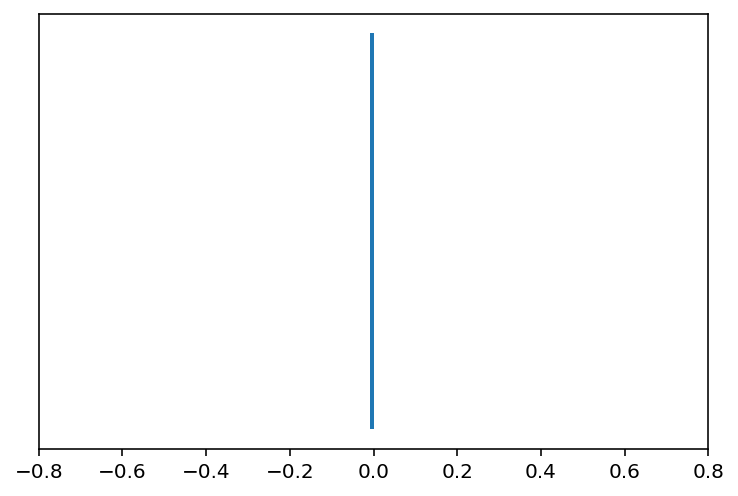

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
ax.barh(0,height=0.1, width=(shap_values[0].sum(1)[sex_A].mean()-shap_values[0].sum(1)[sex_A==False].mean()))

<BarContainer object of 4 artists>

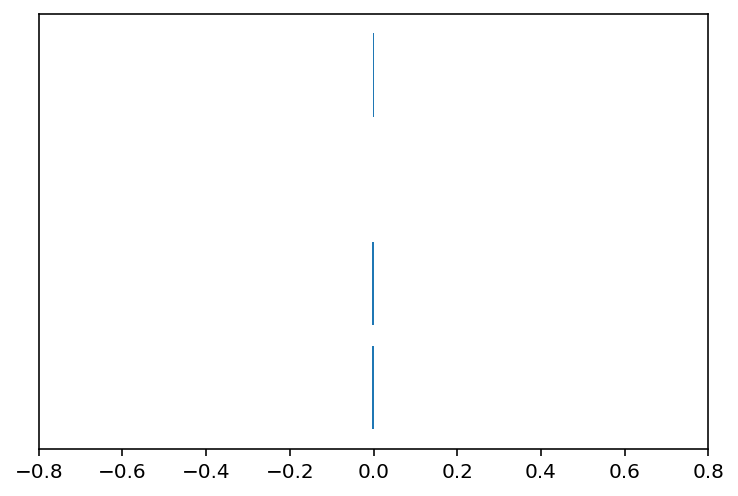

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
wdt = [shap_values[0][:,0][sex_A].mean() - shap_values[0][:,0][sex_A==False].mean(),
       shap_values[0][:,1][sex_A].mean() - shap_values[0][:,1][sex_A==False].mean(),
       shap_values[0][:,2][sex_A].mean() - shap_values[0][:,2][sex_A==False].mean(),
       shap_values[0][:,3][sex_A].mean() - shap_values[0][:,3][sex_A==False].mean()]
ax.barh(y=[1,2,3,4], width=wdt)

In [ ]:
# ltnw.ask("DEF(fem)")
# ltnw.ask("DEF(mal)")
# ltnw.ask("forall ?data_def: DEF(?data_fem)")
# ltnw.ask("forall ?data_def: DEF(?mal)")

Fairness LTN

In [ ]:
ltnw.AXIOMS = {}

In [ ]:
X_B_norm = (X_B-X_B.mean())/X_B.std()
X_B_norm

,Job history,Reported income,Credit inquiries,Late payments
0,-0.427085,-0.316675,-0.614789,-0.728159
1,-1.003802,0.150949,0.061695,1.333154
2,-1.205117,-0.555176,-0.614789,1.333154
3,-0.382479,0.463826,-0.614789,1.333154
4,-1.192617,1.892378,-0.614789,0.302498
...,...,...,...,...
9995,-0.781406,-0.070730,-0.614789,1.333154
9996,-1.344929,-0.439090,1.414665,0.302498
9997,0.159821,0.644409,0.061695,1.333154
9998,-0.603925,0.119477,1.414665,-0.728159


In [ ]:
defsB = X_B_norm[y]
non_defsB = X_B_norm[y==False]
inp_defB = defs.astype(np.float32).to_numpy()
inp_ndefB = non_defs.astype(np.float32).to_numpy()

In [ ]:
ltnw.variable("?data_defB",inp_defB)
ltnw.variable("?data_ndefB",inp_ndefB)

tensor([[-0.4271, -0.5825, -0.6148, -0.7281],
        [-1.0038,  0.3048,  0.0617,  1.3331],
        [-0.3825,  0.2177, -0.6148,  1.3331],
        ...,
        [ 0.3591, -1.1149, -0.6148,  0.3025],
        [ 0.1598,  0.4028,  0.0617,  1.3331],
        [-0.6039,  0.8462,  1.4147, -0.7281]])

In [ ]:
ltnw.axiom("forall ?data_defB: D(?data_defB)")
ltnw.axiom("forall ?data_ndefB: ~D(?data_ndefB)")
ltnw.AXIOMS

{'forall ?data_defB: D(?data_defB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_ndefB: ~D(?data_ndefB)': tensor([0.6163], device='cuda:0', grad_fn=<MulBackward0>)}

In [ ]:
logger.setLevel(logging.INFO)

ltnw.initialize_knowledgebase(initial_sat_level_threshold=.99)
sat_level=ltnw.train(track_sat_levels=500, sat_level_epsilon=.01,max_epochs=1000)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = tensor(0.6162, device='cuda:0', grad_fn=<RsubBackward1>)
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
sat_level=ltnw.train(track_sat_levels=500, sat_level_epsilon=.01,max_epochs=10000)

INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1500 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2500 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 3000 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 3500 sat level -----> tensor(0.6162, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRA

In [ ]:
logger.setLevel(logging.CRITICAL)
explainer_B = shap.KernelExplainer(f, shap.sample(X_B_norm, 100))
shap_values_B = explainer_B.shap_values(X_B_norm)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


<BarContainer object of 1 artists>

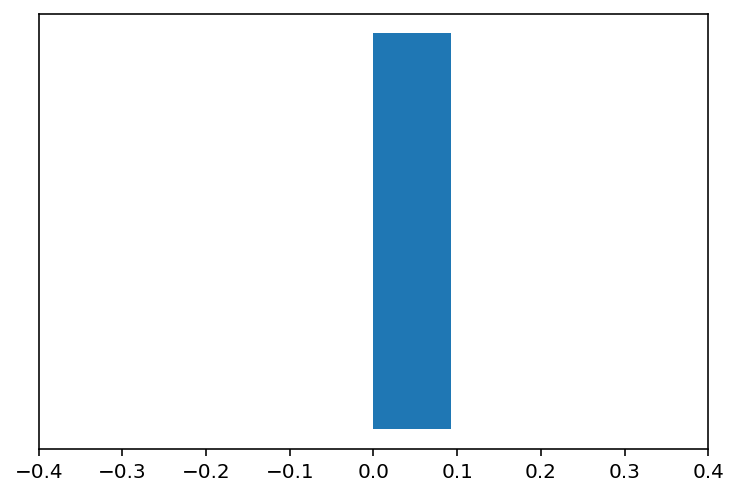

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-0.4, 0.4)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
ax.barh(0,height=0.1, width=(shap_values_B[0].sum(1)[sex_B].mean()-shap_values_B[0].sum(1)[sex_B==False].mean()))

<BarContainer object of 4 artists>

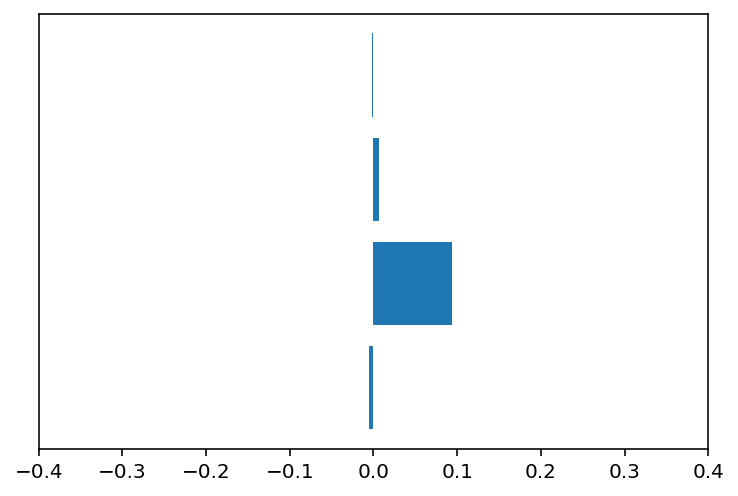

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(-0.4, 0.4)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
wdt = [shap_values_B[0][:,0][sex_B].mean() - shap_values_B[0][:,0][sex_B==False].mean(),
       shap_values_B[0][:,1][sex_B].mean() - shap_values_B[0][:,1][sex_B==False].mean(),
       shap_values_B[0][:,2][sex_B].mean() - shap_values_B[0][:,2][sex_B==False].mean(),
       shap_values_B[0][:,3][sex_B].mean() - shap_values_B[0][:,3][sex_B==False].mean()]
ax.barh(y=[1,2,3,4], width=wdt)

In [ ]:
X_B_norm['customer quality'] = cquality
X_B_norm['customer class'] = pd.qcut(X_B_norm['customer quality'],5, labels=[0,1,2,3,4])

In [ ]:
X_B_norm[sex_B==False]['customer class'].value_counts()

0    1022
2    1016
4     992
1     946
3     939
Name: customer class, dtype: int64

In [ ]:
X_B_norm[sex_B]['customer class']

1       2
2       0
4       4
5       4
6       2
       ..
9989    3
9991    1
9994    2
9996    1
9998    4
Name: customer class, Length: 5085, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [ ]:
X_B_norm

,Job history,Reported income,Credit inquiries,Late payments,customer quality,customer class
0,-0.427085,-0.316675,-0.614789,-0.728159,0.098709,3
1,-1.003802,0.150949,0.061695,1.333154,0.031823,2
2,-1.205117,-0.555176,-0.614789,1.333154,0.000962,0
3,-0.382479,0.463826,-0.614789,1.333154,0.018471,2
4,-1.192617,1.892378,-0.614789,0.302498,0.137896,4
...,...,...,...,...,...,...
9995,-0.781406,-0.070730,-0.614789,1.333154,0.015061,1
9996,-1.344929,-0.439090,1.414665,0.302498,0.004611,1
9997,0.159821,0.644409,0.061695,1.333154,0.037017,2
9998,-0.603925,0.119477,1.414665,-0.728159,0.122765,4


In [ ]:
# defs = X_A_norm[y].iloc[:,:-1]
# non_defs = X_A_norm[y==False].iloc[:,:-1]
# print(defs.shape,non_defs.shape)

Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [ ]:
X_A_F = X_B_norm[sex_B]
X_A_M = X_B_norm[sex_B==False]
print(X_A_F.shape,X_A_M.shape)

(5085, 6) (4915, 6)


In [ ]:
class1F = X_A_F[X_A_F['customer class'] == 0]
class2F = X_A_F[X_A_F['customer class'] == 1]
class3F = X_A_F[X_A_F['customer class'] == 2]
class4F = X_A_F[X_A_F['customer class'] == 3]
class5F = X_A_F[X_A_F['customer class'] == 4]
class1M = X_A_M[X_A_M['customer class'] == 0]
class2M = X_A_M[X_A_M['customer class'] == 1]
class3M = X_A_M[X_A_M['customer class'] == 2]
class4M = X_A_M[X_A_M['customer class'] == 3]
class5M = X_A_M[X_A_M['customer class'] == 4]

In [ ]:
class2M

,Job history,Reported income,Credit inquiries,Late payments,customer quality,customer class
14,-0.657942,0.748368,2.767634,1.333154,0.003796,1
18,-0.195440,0.273449,0.061695,1.333154,0.008075,1
23,-0.784525,0.904446,1.414665,0.302498,0.011983,1
40,-1.207946,0.902666,0.061695,1.333154,0.003760,1
48,-1.649408,0.046727,-0.614789,-0.728159,0.014877,1
...,...,...,...,...,...,...
9969,1.381641,-0.774827,0.738180,-0.728159,0.004279,1
9973,1.262467,-0.114822,0.738180,1.333154,0.004398,1
9987,1.343894,0.182106,0.738180,-0.728159,0.011893,1
9992,-0.856477,0.967530,1.414665,-0.728159,0.013503,1


In [ ]:
inpclass1f = class1F.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass2f = class2F.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass3f = class3F.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass4f = class4F.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass5f = class5F.iloc[:,:-2].astype(np.float32).to_numpy()

inpclass1m = class1M.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass2m = class2M.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass3m = class3M.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass4m = class4M.iloc[:,:-2].astype(np.float32).to_numpy()
inpclass5m = class5M.iloc[:,:-2].astype(np.float32).to_numpy()

In [ ]:
ltnw.AXIOMS

{'forall ?data_defB: D(?data_defB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_ndefB: ~D(?data_ndefB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>)}

In [ ]:
ltnw.variable("?class1F",inpclass1f)
ltnw.variable("?class2F",inpclass2f)
ltnw.variable("?class3F",inpclass3f)
ltnw.variable("?class4F",inpclass4f)
ltnw.variable("?class5F",inpclass5f)

ltnw.variable("?class1M",inpclass1m)
ltnw.variable("?class2M",inpclass2m)
ltnw.variable("?class3M",inpclass3m)
ltnw.variable("?class4M",inpclass4m)
ltnw.variable("?class5M",inpclass5m)

tensor([[ 0.2824,  0.4560, -0.6148,  0.3025],
        [-0.5601,  0.4195, -0.6148, -0.7282],
        [ 0.7287,  0.6018,  0.7382,  0.3025],
        ...,
        [ 0.1843, -0.8009, -0.6148, -0.7282],
        [ 1.2814,  1.1268, -0.6148,  0.3025],
        [ 0.1331,  1.1190, -0.6148, -1.7588]])

In [ ]:
ltnw.AXIOMS = {}

In [ ]:
ltnw.axiom("forall ?class1F, ?class1M: D(?class1F) % D(?class1M)")
ltnw.axiom("forall ?class2F, ?class2M: D(?class2F) % D(?class2M)")
# ltnw.axiom("forall ?class3F, ?class3M: D(?class3F) % D(?class3M)")
ltnw.axiom("forall ?class4F, ?class4M: D(?class4F) % D(?class4M)")
# ltnw.axiom("forall ?class5F, ?class5M: D(?class5F) % D(?class5M)")

tensor([0.7802], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
ltnw.AXIOMS

{'forall ?class1F, ?class1M: D(?class1F) % D(?class1M)': tensor([0.7505], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class2F, ?class2M: D(?class2F) % D(?class2M)': tensor([0.7377], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class4F, ?class4M: D(?class4F) % D(?class4M)': tensor([0.7802], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_defB: D(?data_defB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_ndefB: ~D(?data_ndefB)': tensor([0.6163], device='cuda:0', grad_fn=<MulBackward0>)}

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for i in ltnw.AXIOMS:
  ltnw.AXIOMS["{axi}".format(axi=i)] = ltnw.AXIOMS["{axi}".format(axi=i)].to(device)
ltnw.AXIOMS

{'forall ?class1F, ?class1M: D(?class1F) % D(?class1M)': tensor([0.7505], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class2F, ?class2M: D(?class2F) % D(?class2M)': tensor([0.7377], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class3F, ?class3M: D(?class3F) % D(?class3M)': tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>),
 'forall ?class4F, ?class4M: D(?class4F) % D(?class4M)': tensor([0.7802], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class5F, ?class5M: D(?class5F) % D(?class5M)': tensor([1.], device='cuda:0', grad_fn=<CopyBackwards>),
 'forall ?data_defB: D(?data_defB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_ndefB: ~D(?data_ndefB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>)}

In [ ]:
# ltnw.AXIOMS.values().to(device)

In [ ]:
ltnw.AXIOMS

{'forall ?class1F, ?class1M: D(?class1F) % D(?class1M)': tensor([0.7505], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class2F, ?class2M: D(?class2F) % D(?class2M)': tensor([0.7377], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class3F, ?class3M: D(?class3F) % D(?class3M)': tensor([1.], requires_grad=True),
 'forall ?class4F, ?class4M: D(?class4F) % D(?class4M)': tensor([0.7802], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?class5F, ?class5M: D(?class5F) % D(?class5M)': tensor([1.], requires_grad=True),
 'forall ?data_defB: D(?data_defB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>),
 'forall ?data_ndefB: ~D(?data_ndefB)': tensor([0.6162], device='cuda:0', grad_fn=<MulBackward0>)}

In [ ]:
logger.setLevel(logging.INFO)

ltnw.initialize_knowledgebase(initial_sat_level_threshold=.99)
sat_level=ltnw.train(track_sat_levels=500, sat_level_epsilon=.01,max_epochs=10000)

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = tensor(0.7002, device='cuda:0', grad_fn=<RsubBackward1>)
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> tensor(0.7002, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 500 sat level -----> tensor(0.7884, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> tensor(0.7998, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 1500 sat level -----> tensor(0.8000, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> tensor(0.8000, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 2500 sat level -----> tensor(0.8000, device='cuda:0', grad_fn=<MeanBackward0>)
INFO:logictensornetworks_wrapper:TRAINING 3

In [ ]:
logger.setLevel(logging.CRITICAL)
explainer_C = shap.KernelExplainer(f, shap.sample(X_B_norm.iloc[:,:-2], 100))
shap_values_C = explainer_C.shap_values(X_B_norm.iloc[:,:-2])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [ ]:
shap_values_C[0].shape

(10000, 4)

<BarContainer object of 1 artists>

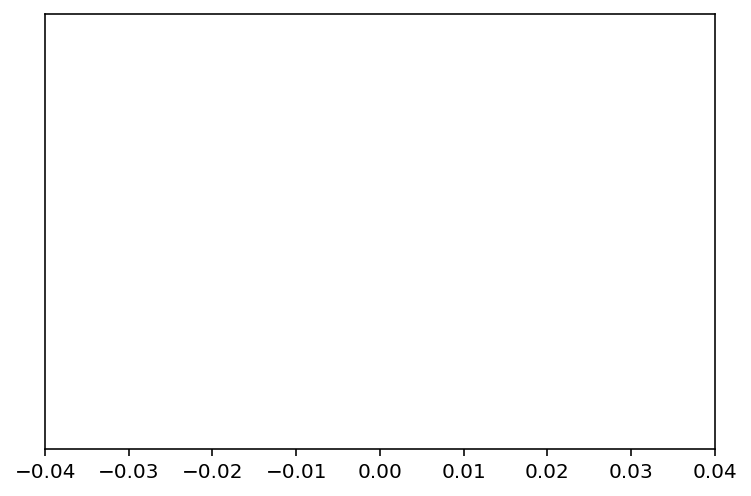

In [ ]:
fig, ax = plt.subplots()
# ax.set_xlim(-0.00005, 0.00005)
ax.set_xlim(-0.04, 0.04)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
ax.barh(0,height=0.1, width=(shap_values_C[0].sum(1)[sex_B].mean()-shap_values_C[0].sum(1)[sex_B==False].mean()))

<BarContainer object of 4 artists>

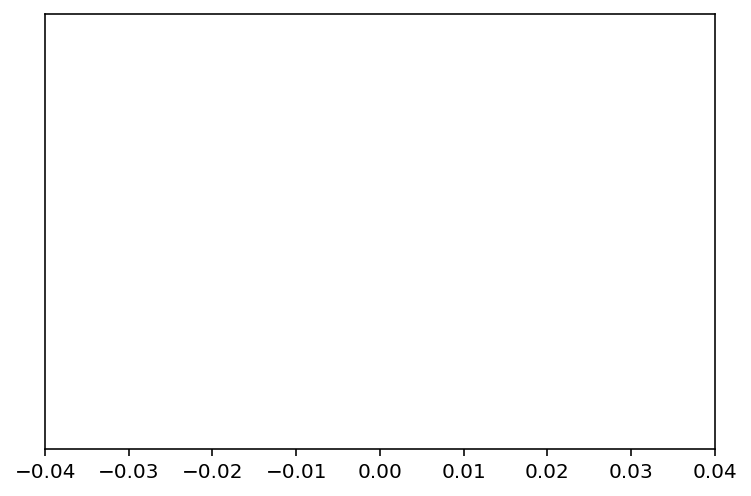

In [ ]:
fig, ax = plt.subplots()
# ax.set_xlim(-0.00005, 0.00005)
ax.set_xlim(-0.04, 0.04)
ax.get_yaxis().set_visible(False)
ax.set_xlabel = glabel
wdt = [shap_values_C[0][:,0][sex_B].mean() - shap_values_C[0][:,0][sex_B==False].mean(),
       shap_values_C[0][:,1][sex_B].mean() - shap_values_C[0][:,1][sex_B==False].mean(),
       shap_values_C[0][:,2][sex_B].mean() - shap_values_C[0][:,2][sex_B==False].mean(),
       shap_values_C[0][:,3][sex_B].mean() - shap_values_C[0][:,3][sex_B==False].mean()]
ax.barh(y=[1,2,3,4], width=wdt)

In [ ]:
shap_values_C[0][:,0][sex_B].mean() - shap_values_C[0][:,0][sex_B==False].mean()

3.819995483270322e-07